In [31]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
# preparing data
from sklearn.decomposition import PCA
from methods import *
from models import *
import pandas as pd
import numpy as np
import torch
import math
import os
from os import path
import torch.nn as nn

model_name = "VAE"
DATASET = 'medical_data'

"""___________________Hyper Parameters________________________"""
CROSS_VALIDATION_SHUFFLE = True
TRIM_DATA = True
FILTER_CORRCOEF = True
REMOVE_NOISE = True
REMOVE_NOISE_THRESHOLD = 5
DENOISE = False
NOISE_FACTOR = 0.05
NOISE_FRACTION = 0.8
NORMALIZE_DATA = False
LATENT_DIM = 8
HIDDEN_DIM = 32
WEIGHT_DECAY = 0
LEARNING_RATE = 1e-4
SIGMA = 1e-0
EPOCHS = 4000
ACTIVATION = 'leaky_relu'
BATCH_SIZE = 1024
INITIALIZATION = 'xavier_normal'
"""___________________________________________________________"""
#device = torch.device("mps")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if DATASET == 'network_data':
    raw_data = np.loadtxt('../data/network_flow_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_data = np.loadtxt('../data/network_flow_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
elif DATASET == 'medical_data':
    raw_data = np.loadtxt('../data/medical_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_data = np.loadtxt('../data/medical_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_data = np.loadtxt('../data/medical_attack_data_undetected.csv', skiprows=1, delimiter=',')[:,:-1]
elif DATASET == 'full_data':
    raw_data = np.concatenate((np.loadtxt('../data/network_flow_regular_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=1)
    anomalous_data = np.concatenate((np.loadtxt('../data/network_flow_attack_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=1)
elif DATASET == 'network_data1':
    raw_data = np.loadtxt('../data/network_flow1_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_data = np.loadtxt('../data/network_flow1_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
elif DATASET == 'medical_data1':
    #raw_data = np.loadtxt('../data/medical_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    #raw_data = np.loadtxt('../data/medical1_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    raw_data = np.concatenate((np.loadtxt('../data/medical_regular_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical1_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=0)
    anomalous_data = np.loadtxt('../data/medical_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
    #anomalous_data = np.loadtxt('../data/medical_attack_data_undetected.csv', skiprows=1, delimiter=',')[:,:-1]
elif DATASET == 'full_data1':
    raw_data = np.concatenate((np.loadtxt('../data/network_flow1_regular_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical1_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=1)
    anomalous_data = np.concatenate((np.loadtxt('../data/network_flow1_attack_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical1_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=1)
elif DATASET == 'network_data2':
    raw_data = np.loadtxt('../data/network_flow2_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_data = np.loadtxt('../data/network_flow2_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]



train_data, validation_data, test_data, anomalous_data = preProcessData_OneClass(raw_data, anomalous_data, trim=TRIM_DATA, trim_threshold=0.98, normalize=NORMALIZE_DATA,
            filterLinearDependencies=True, filter_threshold=0.98, removeNoise=REMOVE_NOISE, noise_threshold=REMOVE_NOISE_THRESHOLD)

train_data, validation_data, test_data, anomalous_data = toTorchTensor(device, train_data, validation_data, test_data, anomalous_data)
NUM_FEATURE = len(train_data[0])
print(train_data.shape)
print(torch.max(anomalous_data))


Train data shape after trim:  (8005, 7)
Train data shape after normalize:  (8005, 7)
Train data shape after filter corrcoef:  (8005, 7)
removeNoise = True ---- remaining Data Shape =  (7870, 7)
torch.Size([7870, 7])
tensor(149.)


In [33]:
criterion = nn.MSELoss(reduction='sum')
model = VAE(NUM_FEATURE, latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM, activation=ACTIVATION, initialization=INITIALIZATION, sigma=SIGMA)

In [34]:
# train
loss_array = train(model, 'SGD', EPOCHS, train_data, train_data, criterion, batch_size=BATCH_SIZE, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        ,grad_limit=1e3)
torch.save(model.state_dict(), '../model/param_VAE')

epoch : 1/4000, loss = 160302.747903
epoch : 2/4000, loss = 931782.740025
epoch : 3/4000, loss = 1449747.777637
epoch : 4/4000, loss = 25674.756671
epoch : 5/4000, loss = 18775.710673
epoch : 6/4000, loss = 12790.118551
epoch : 7/4000, loss = 8385.518361
epoch : 8/4000, loss = 5121.486849
epoch : 9/4000, loss = 4052.004193
epoch : 10/4000, loss = 4499.426747
epoch : 11/4000, loss = 2719.575842
epoch : 12/4000, loss = 1688.158609
epoch : 13/4000, loss = 2450.993933
epoch : 14/4000, loss = 2011.013088
epoch : 15/4000, loss = 2272.596680
epoch : 16/4000, loss = 2178.028224
epoch : 17/4000, loss = 2125.271998
epoch : 18/4000, loss = 2065.303050
epoch : 19/4000, loss = 2037.002065
epoch : 20/4000, loss = 2003.975889
epoch : 21/4000, loss = 1980.312913
epoch : 22/4000, loss = 1972.885515
epoch : 23/4000, loss = 1937.720886
epoch : 24/4000, loss = 1942.012834
epoch : 25/4000, loss = 1880.632767
epoch : 26/4000, loss = 1914.506353
epoch : 27/4000, loss = 1882.636785
epoch : 28/4000, loss = 186

In [35]:
#model.load_state_dict(torch.load('../model/param_AE'))
model.eval()
batch = torch.mean(train_data, dim=0, keepdim=True).expand(train_data.shape)[:BATCH_SIZE,]
code = torch.randn_like(torch.ones(len(batch), LATENT_DIM))
print(model.decode(code)[0].detach().numpy())
print(batch[0].detach().numpy())
print(criterion(model.decode(code), batch))
print('___________')
print(code[0])
print(model.decode(code[0]))
print(train_data[0])
print(criterion(model.decode(code[0]), train_data[0]))
print(torch.square(model.decode(code[0]) - train_data[0]))

[100.018845    74.97675    147.92657     83.47019     74.5886
  19.712477     0.39291346]
[ 97.93913    75.85095   143.09898    80.11092    75.26176    20.712198
   0.2641779]
tensor(28275.4727, grad_fn=<MseLossBackward0>)
___________
tensor([-1.0722, -1.3138, -1.0119, -0.8170, -0.4937, -0.9621, -1.2956,  1.0804])
tensor([100.0189,  74.9768, 147.9266,  83.4702,  74.5886,  19.7125,   0.3929],
       grad_fn=<AddBackward0>)
tensor([ 99.0000,  72.0000, 142.0000,  72.0000,  71.0000,  26.0000,   0.3600])
tensor(229.0013, grad_fn=<MseLossBackward0>)
tensor([1.0381e+00, 8.8612e+00, 3.5124e+01, 1.3157e+02, 1.2878e+01, 3.9533e+01,
        1.0833e-03], grad_fn=<PowBackward0>)


In [36]:
# evaluation
#model.load_state_dict(torch.load('../model/param_AE'))
model.eval()
validation_batch_size = 1
lcs_array = torch.tensor([[0 for _ in range(NUM_FEATURE)]])

difference = torch.square(model(train_data) - train_data)
lcs_array = torch.div(difference, torch.sum(difference, 1, True).expand(difference.shape))
lcs_mean = torch.mean(lcs_array, 0, True)
l = len(validation_data)
permutation = np.random.permutation(l)
for i in range(0, l, validation_batch_size):
    batch_idc = permutation[i:i+validation_batch_size]
    batch = validation_data[batch_idc,]
    loss = 0
    # compute reconstructions
    outputs = model(batch)

    #print(f"input:{batch[0].data}\noutput:{outputs[0].data}")
    
    # compute the epoch validation loss
    loss = criterion(outputs, batch).item()
    loss /= len(batch)
    #i_loss = torch.sum(torch.square(batch[0]-outputs[0]))
    #print(f"Batch Average Reconstruciton Loss:{loss}")
    lcs = torch.sum((torch.square(outputs - batch) / len(batch)), 0, keepdim=False) / loss
    #print(f"Loss Contribution Score: {(lcs)}") 

lcs_array = lcs_array[1:].detach()
lcs_mean_val = torch.mean(lcs_array, dim=0)
print("Validation average lcs: ",lcs_mean_val.numpy())

print(f"Train average loss:{criterion(model(train_data), train_data) / len(train_data)}")

print(f"Validation average loss:{criterion(model(validation_data), validation_data) / len(validation_data)}")
print("Test average loss: ", criterion(model(test_data), test_data)/len(test_data))
print("Anomalous average loss: ", criterion(model(anomalous_data), anomalous_data)/len(anomalous_data))

Validation average lcs:  [0.09920615 0.166898   0.24879543 0.21483834 0.14761391 0.12178154
 0.00086665]
Train average loss:63.385189056396484
Validation average loss:125.79875183105469
Test average loss:  tensor(692.7471, grad_fn=<DivBackward0>)
Anomalous average loss:  tensor(95.5463, grad_fn=<DivBackward0>)


In [37]:
# test
#model.load_state_dict(torch.load('../model/param_AE'))
model.eval()
model_name = "VAE"

# Collapse
if True:
    loss_test = []
    lcs_array_test = torch.tensor([[0 for _ in range(NUM_FEATURE)]])

    y_scores = []
    y_scores_lcs = []
    kl_div_test = []
    y_ground_truth = []
    vae_kl_test = []
    # Define KL Loss
    kl_loss = nn.KLDivLoss(reduction="batchmean", log_target=False)
    l = len(test_data)
    permutation = np.random.permutation(l)
    for i in range(0, l, 1):
        batch_idc = permutation[i:i+1]
        batch = test_data[batch_idc,]
        loss = 0
        
        # compute reconstructions
        outputs = model(batch)

        #print(f"input:{batch[0].data}\noutput:{outputs[0].data}")
        
        # compute the epoch test loss
        loss = criterion(outputs, batch).item()
        vae_kl_test.append(model.KLD.item())
        # append loss and class label
        y_scores.append(loss)
        y_ground_truth.append(0)
        #i_loss = torch.sum(torch.square(batch[0]-outputs[0]))
        loss_test.append(loss)
        #print(f"Reconstruciton Loss:{loss}")
        
        #lcs = torch.sum((torch.square(outputs - batch)), 0, keepdim=False) / loss
        lcs = torch.square(outputs - batch) / loss
        #print(f"Loss Contribution Score: {(lcs)}")
        lcs = torch.reshape(lcs, (1, NUM_FEATURE))
        # KL Divergence
        this_kld = kl_loss(torch.log(lcs), lcs_mean.view(1, NUM_FEATURE)).detach().numpy()
        #print(this_kld)
        kl_div_test.append(this_kld)
        lcs_array_test = torch.cat((lcs_array_test, lcs), 0)

    lcs_array_test = lcs_array_test[1:].detach()
    lcs_mean_test = torch.mean(lcs_array_test, dim=0)
    print("Test average lcs: ", lcs_mean_test.numpy())
    # Loss Contribution Score
    y_scores_lcs = torch.sum((torch.square(lcs_array_test - lcs_mean)), dim=1, keepdim=False)
    lcs_array_test = lcs_array_test.numpy()

    path = "../result_lcs"
    filename = model_name +  "_lcs_normal.csv"
    pathfile = os.path.normpath(os.path.join(path, filename))
    file_present = os.path.isfile(pathfile)
    if not file_present:
        df = pd.DataFrame(lcs_array_test) #convert to a dataframe
        #df.to_csv(pathfile, index=True) #save to file
        print(f"Saved file to {pathfile}")
    else:
        i = 1
        while file_present:
            print("FILE PRESENT "+ str(i))
            filename = model_name + "_lcs_normal_" + str(i) + ".csv"
            pathfile = os.path.normpath(os.path.join(path, filename))
            file_present = os.path.isfile(pathfile)
            i += 1
        df = pd.DataFrame(lcs_array_test) #convert to a dataframe
        #df.to_csv(pathfile, index=True) #save to file
        print(f"Saved file to {pathfile}")

    #________________________________________________________________________#

    # anomaly detection test
    loss_attack =[]
    lcs_array_attack = torch.tensor([[0 for _ in range(NUM_FEATURE)]])
    kl_div_attack = []
    vae_kl_attack = []
    l = len(anomalous_data)
    permutation = np.random.permutation(l)
    for i in range(0, l, 1):
        batch_idc = permutation[i:i+1]
        batch = anomalous_data[batch_idc,]
        
        loss = 0
        # compute reconstructions
        outputs = model(batch)
        # compute the epoch test loss
        loss = criterion(outputs, batch).item()
        vae_kl_attack.append(model.KLD.item())
        # append loss and class label
        y_scores.append(loss)
        y_ground_truth.append(1)
        loss_attack.append(loss)
        #print(f"Reconstruciton Loss:{loss}")
        
        #lcs = torch.sum((torch.square(outputs - batch)), 0, keepdim=False) / loss
        lcs = torch.square(outputs - batch) / loss
        #print(f"Loss Contribution Score: {(lcs)}")
        # KL Divergence
        this_kld = kl_loss(torch.log(lcs), lcs_mean.view(1, NUM_FEATURE)).detach().numpy()
        #print(this_kld)
        kl_div_attack.append(this_kld)

        lcs_array_attack = torch.cat((lcs_array_attack, torch.reshape(lcs, (1, NUM_FEATURE))), 0)

    lcs_array_attack = lcs_array_attack[1:].detach()
    lcs_mean_attack = torch.mean(lcs_array_attack, dim=0)
    print("Anomalous average lcs: ", lcs_mean_attack.numpy())
    # Loss Contribution Score
    y_scores_lcs = torch.cat((y_scores_lcs, torch.sum((torch.square(lcs_array_attack - lcs_mean)), dim=1, keepdim=False))).detach().numpy()
    
    lcs_array_attack = lcs_array_attack.numpy()
    
    path = "../result_lcs"
    filename = model_name + "_lcs_attack.csv"
    pathfile = os.path.normpath(os.path.join(path, filename))
    file_present = os.path.isfile(pathfile) 
    if not file_present:
        df = pd.DataFrame(lcs_array_attack) #convert to a dataframe
        #df.to_csv(pathfile, index=True) #save to file
    else:
        i = 1
        while file_present:
            print("FILE PRESENT "+ str(i))
            filename = model_name + "_lcs_attack_" + str(i) + ".csv"
            pathfile = os.path.normpath(os.path.join(path, filename))
            file_present = os.path.isfile(pathfile)
            i += 1
        df = pd.DataFrame(lcs_array_attack) #convert to a dataframe
        #df.to_csv(pathfile, index=True) #save to file
        print(f"Saved file to {filename}")


Test average lcs:  [0.1012567  0.16830695 0.25858203 0.20434001 0.14780839 0.11886481
 0.00084112]
Saved file to ../result_lcs/VAE_lcs_normal.csv
Anomalous average lcs:  [0.08952055 0.17242886 0.22990881 0.18493481 0.15623383 0.1660259
 0.00094721]


In [38]:
# use TSNE to show code distribution
PERPLEXITY = 10
if True:
    model.eval()
    full_code = model.encode(torch.cat((test_data, anomalous_data), dim=0)).detach().numpy()
    full_label = [0 for _ in range(len(test_data))] + [1 for _ in range(len(anomalous_data))]
    from sklearn.manifold import TSNE

    # We want to get TSNE embedding with 2 dimensions
    n_components = 2
    tsne = TSNE(n_components, perplexity=PERPLEXITY)
    #print(full_data.shape)
    tsne_code = tsne.fit_transform(full_code)
# use TSNE to show LCS 
if True:
    tsne = TSNE(n_components, perplexity=PERPLEXITY)
    full_lcs = np.concatenate((lcs_array_test, lcs_array_attack), axis=0)
    #print(full_data.shape)
    tsne_lcs = tsne.fit_transform(full_lcs)

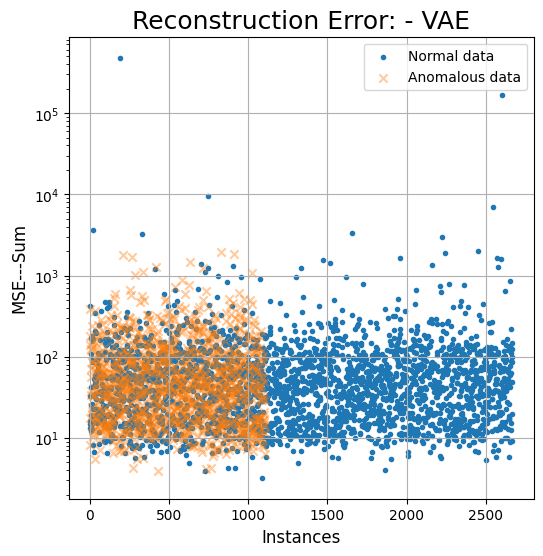

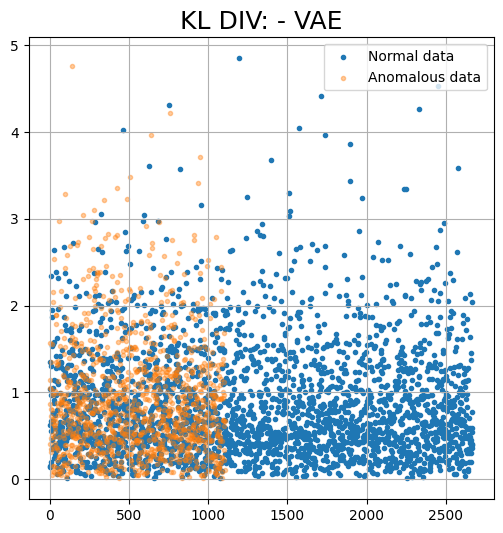

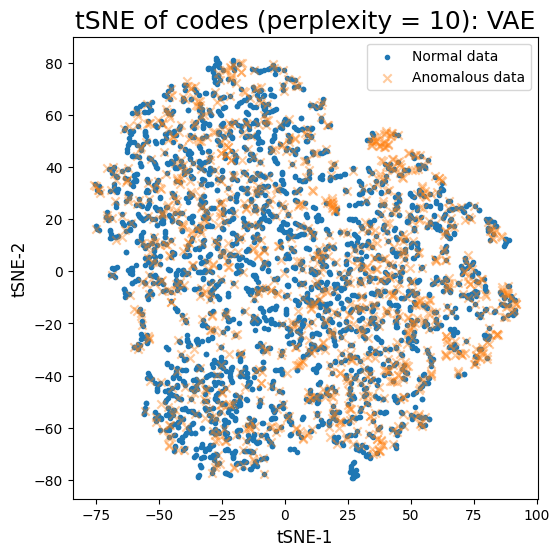

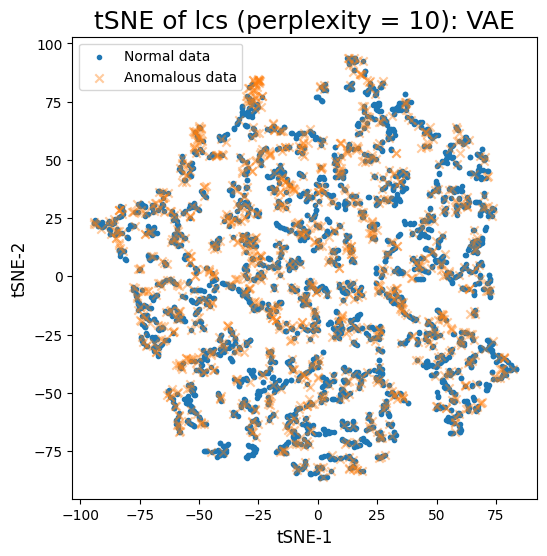

In [39]:
import matplotlib.pyplot as plt
if True:
    fig = plt.figure(figsize = (6,6))

    ax = fig.add_subplot(1,1,1)

    ax.set_xlabel('Instances', fontsize = 12)
    ax.set_ylabel('MSE---Sum', fontsize = 12)
    ax.set_yscale('log')
    #ax.set_ylim(1e2, 1e9)
    ax.set_title('Reconstruction Error: - ' + model_name, fontsize = 18)
    ax.grid()
    a = ax.scatter(np.arange(len(loss_test)), loss_test, marker=".")
    b = ax.scatter(np.arange(len(loss_attack)), loss_attack, marker="x", alpha=0.4)
    a.set_label('Normal data')
    b.set_label('Anomalous data')
    ax.legend()

    fig2 = plt.figure(figsize = (6,6))
    ax2 = fig2.add_subplot(1,1,1)
    ax2.set_title('KL DIV: - ' + model_name, fontsize = 18)
    ax2.scatter(np.arange(len(kl_div_test)), kl_div_test, marker=".").set_label('Normal data')
    ax2.scatter(np.arange(len(kl_div_attack)), kl_div_attack, marker=".", alpha=0.4).set_label('Anomalous data')
    #ax2.set_ylim(-0.1, 0.1)
    ax2.grid()
    ax2.legend()

    fig3 = plt.figure(figsize = (6,6))
    ax3 = fig3.add_subplot(1,1,1)
    l1, l2 = len(test_data), len(anomalous_data)
    ax3.scatter(tsne_code[:l1,0], tsne_code[:l1,1], marker=".").set_label('Normal data')
    ax3.scatter(tsne_code[l1:,0], tsne_code[l1:,1], marker="x", alpha=0.4).set_label('Anomalous data')
    ax3.set_title(('tSNE of codes (perplexity = ' + str(PERPLEXITY) + '): ' + model_name), fontsize = 18)
    ax3.set_xlabel('tSNE-1', fontsize = 12)
    ax3.set_ylabel('tSNE-2', fontsize = 12)
    ax3.legend()

    # Plot the result of TSNE
    fig4 = plt.figure(figsize = (6,6))
    ax4 = fig4.add_subplot(1,1,1
    #, projection='2d'
    )
    l1, l2 = len(test_data), len(anomalous_data)
    ax4.scatter(tsne_lcs[:l1,0], tsne_lcs[:l1,1], 
    #np.arange(l1), 
    marker=".").set_label('Normal data')
    ax4.scatter(tsne_lcs[l1:,0], tsne_lcs[l1:,1], 
    #np.arange(l2), 
    marker="x", alpha=0.4).set_label('Anomalous data')
    ax4.set_title(('tSNE of lcs (perplexity = ' + str(PERPLEXITY) + '): ' + model_name), fontsize = 18)
    ax4.set_xlabel('tSNE-1', fontsize = 12)
    ax4.set_ylabel('tSNE-2', fontsize = 12)
    ax4.legend()

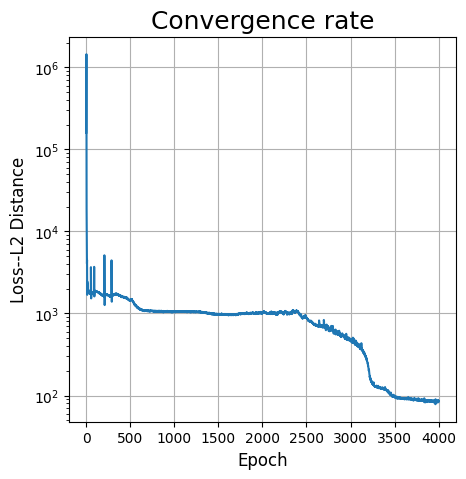

In [40]:
# Convergence Rate
if True:
    fig = plt.figure(figsize = (5, 5))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Epoch', fontsize = 12)
    ax.set_ylabel('Loss--L2 Distance', fontsize = 12)
    ax.set_yscale('log')
    #ax.set_ylim(1e5, 1e9)
    ax.set_title('Convergence rate', fontsize = 18)
    ax.grid()
    a = ax.plot(loss_array)

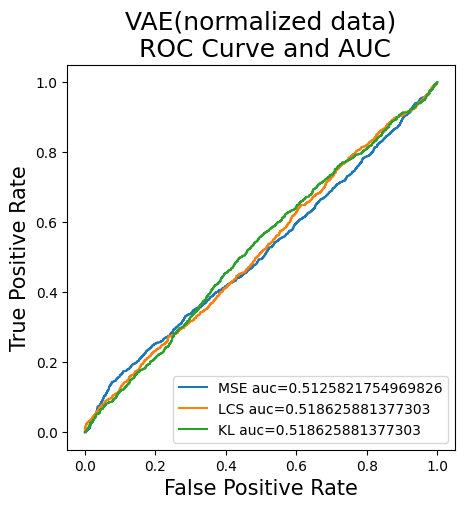

In [41]:
# ROC & AUC
from sklearn import metrics
if True:
    fig = plt.figure(figsize = (5,5))
    ax = fig.add_subplot(1,1,1) 

    fpr_MSE, tpr_MSE, _ = metrics.roc_curve(y_ground_truth,  y_scores)
    auc_MSE = metrics.roc_auc_score(y_ground_truth,  y_scores)
    fpr_LCS, tpr_LCS, _ = metrics.roc_curve(y_ground_truth,  y_scores_lcs)
    auc_LCS = metrics.roc_auc_score(y_ground_truth,  y_scores_lcs)

    y_scores_kl = kl_div_test + kl_div_attack
    fpr_KL, tpr_KL, _ = metrics.roc_curve(y_ground_truth,  y_scores_kl)
    auc_KL = metrics.roc_auc_score(y_ground_truth,  y_scores_kl)


    ax.set_title(model_name+'(normalized data)\n ROC Curve and AUC', fontsize = 18)
    ax.plot(fpr_MSE,tpr_MSE, label="MSE auc="+str(auc_MSE))
    ax.plot(fpr_LCS,tpr_LCS, label="LCS auc="+str(auc_LCS))
    ax.plot(fpr_KL,tpr_KL, label="KL auc="+str(auc_LCS))
    ax.set_xlabel("False Positive Rate", fontsize=15)
    ax.set_ylabel("True Positive Rate", fontsize=15)
    ax.legend(loc=4)

In [42]:
# VAE-GAN
#discriminator = AutoEncoder(NUM_FEATURE, output_feature=1, logit=True)
discriminator = Discriminator(NUM_FEATURE, latent_dim=64, hidden_dim=16, activation='leaky_relu', initialization='xavier_normal')
#generator = VAE(NUM_FEATURE, latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM, activation=ACTIVATION, initialization=INITIALIZATION, sigma=SIGMA)
generator = model
encoder = generator.encoding_layer
decoder = generator.decoding_layer
# optimizer
alpha = 1
optimizer_G = torch.optim.SGD(generator.parameters(), lr=0, weight_decay=WEIGHT_DECAY)
optimizer_Enc = torch.optim.SGD(encoder.parameters(), lr=0, weight_decay=WEIGHT_DECAY)
optimizer_Dec = torch.optim.SGD(decoder.parameters(), lr=0, weight_decay=WEIGHT_DECAY)
optimizer_D = torch.optim.SGD(discriminator.parameters(), lr=LEARNING_RATE*alpha, weight_decay=WEIGHT_DECAY)

In [43]:
# train
BATCH_SIZE = 512
criterion_BCE, criterion_MSE = nn.BCELoss(reduction='sum').to(device), nn.MSELoss(reduction='sum').to(device)
grad_limit = 1e2
for epoch in range(EPOCHS):
    # L_rec, L_GAN, l = 0, 0, len(train_data)
    L_rec, L_D_real, L_D_rec, L_D_noise, l = 0, 0, 0, 0, len(train_data)
    permutation = np.random.permutation(l)
    for i in range(0, l, BATCH_SIZE):
        batch_idc = permutation[i:i+BATCH_SIZE]
        batch_X = train_data[batch_idc,]
        batch_length = len(batch_X)
        # train discriminator
        discriminator.train()
        generator.eval()
        # train on real data
        zero_label, one_label = torch.zeros(batch_length, 1), torch.ones(batch_length, 1)
        loss_d_real = criterion_BCE(discriminator(batch_X), zero_label)
        # train on reconstructed data
        reconstruction= generator(batch_X)
        loss_d_rec = criterion_BCE(discriminator(reconstruction), one_label)
        # train on data generated from latent space sample
        z_p = torch.normal(torch.zeros(batch_length, LATENT_DIM), torch.ones(batch_length, LATENT_DIM))
        generation = generator.decode(z_p)
        loss_d_noise = criterion_BCE(discriminator(generation), one_label)
        # sum up GAN Loss
        loss_gan = 2*loss_d_real + loss_d_rec + loss_d_noise
        #loss_gan = loss_d_real + loss_d_noise
        discriminator.zero_grad()
        loss_gan.backward(retain_graph=True)
        nn.utils.clip_grad_norm_(discriminator.parameters(), grad_limit)
        optimizer_D.step()

        # train Decoder
        discriminator.eval()
        generator.train()
        # reconstruction loss
        reconstruction = generator(batch_X)
        loss_reconstruction, loss_prior = criterion_MSE(reconstruction, batch_X), generator.KLD
        #loss_reconstruction, loss_prior = criterion_MSE(discriminator.l_output(reconstruction), discriminator.l_output(batch_X)), generator.KLD
        # GAN loss
        loss_d_real = criterion_BCE(discriminator(batch_X), zero_label)
        loss_d_rec = criterion_BCE(discriminator(reconstruction), one_label)
        loss_d_noise = criterion_BCE(discriminator(generation), one_label)
        loss_gan = 2*loss_d_real + loss_d_rec + loss_d_noise
        #loss_gan = loss_d_real + loss_d_noise
        # update Decoder
        loss_Dec = loss_reconstruction - loss_gan
        optimizer_Dec.zero_grad()
        loss_Dec.backward(retain_graph=True)
        nn.utils.clip_grad_norm_(decoder.parameters(), grad_limit)
        optimizer_Dec.step()
        # train Encoder
        # reconstruction loss
        reconstruction = generator(batch_X)
        loss_reconstruction, loss_prior = criterion_MSE(reconstruction, batch_X), generator.KLD
        #loss_reconstruction, loss_prior = criterion_MSE(discriminator.l_output(reconstruction), discriminator.l_output(batch_X)), generator.KLD
        # update Encoder
        loss_Enc = loss_reconstruction + loss_prior
        optimizer_Enc.zero_grad()
        loss_Enc.backward()
        nn.utils.clip_grad_norm_(encoder.parameters(), grad_limit)
        optimizer_Enc.step()

        
        # update losses for output
        L_rec, L_D_real, L_D_rec, L_D_noise = L_rec + loss_Enc, L_D_real + loss_d_real, L_D_rec + loss_d_rec, L_D_noise + loss_d_noise
        #L_rec, L_GAN = L_rec + loss_Enc, L_GAN + loss_gan
    print("epoch : {}/{}, VAE Loss = {:.6f} , L_D_real  = {:.6f} , L_D_rec = {:.6f} , L_D_noise = {:.6f}".format(epoch + 1, EPOCHS, L_rec/l, L_D_real/l, L_D_rec/l, L_D_noise/l))
    #print("epoch : {}/{}, VAE Loss = {:.6f} , GAN Loss = {:.6f}".format(epoch + 1, EPOCHS, L_rec/l, L_GAN/l))

epoch : 1/4000, VAE Loss = 70.734291 , L_D_real  = 0.567026 , L_D_rec = 1.052804 , L_D_noise = 1.047487
epoch : 2/4000, VAE Loss = 70.853294 , L_D_real  = 0.681027 , L_D_rec = 0.711265 , L_D_noise = 0.700807
epoch : 3/4000, VAE Loss = 70.751564 , L_D_real  = 0.643995 , L_D_rec = 0.739259 , L_D_noise = 0.722954
epoch : 4/4000, VAE Loss = 70.955017 , L_D_real  = 0.646418 , L_D_rec = 0.736314 , L_D_noise = 0.718926
epoch : 5/4000, VAE Loss = 70.490013 , L_D_real  = 0.655221 , L_D_rec = 0.722998 , L_D_noise = 0.707732
epoch : 6/4000, VAE Loss = 70.648956 , L_D_real  = 0.658700 , L_D_rec = 0.716208 , L_D_noise = 0.698049
epoch : 7/4000, VAE Loss = 71.019180 , L_D_real  = 0.699089 , L_D_rec = 0.669976 , L_D_noise = 0.655814
epoch : 8/4000, VAE Loss = 70.585052 , L_D_real  = 0.715185 , L_D_rec = 0.653214 , L_D_noise = 0.635610
epoch : 9/4000, VAE Loss = 70.704063 , L_D_real  = 0.713896 , L_D_rec = 0.654621 , L_D_noise = 0.634779
epoch : 10/4000, VAE Loss = 70.940269 , L_D_real  = 0.719217 , L

In [44]:
print(discriminator(torch.rand(1,NUM_FEATURE)))

tensor([[0.3983]], grad_fn=<SigmoidBackward0>)


In [45]:
pred_threshold = 0
print("Test Recall: ", (torch.sum(discriminator(anomalous_data) > pred_threshold) / len(anomalous_data)).item())
print("Test Precision: ", (torch.sum(discriminator(anomalous_data) > pred_threshold) / (torch.sum(discriminator(anomalous_data) > pred_threshold) + torch.sum(discriminator(test_data) > pred_threshold))).item())
print(torch.sum(discriminator(anomalous_data) > pred_threshold))
print(torch.sum(discriminator(test_data) > pred_threshold))

Test Recall:  1.0
Test Precision:  0.2929801344871521
tensor(1106)
tensor(2669)


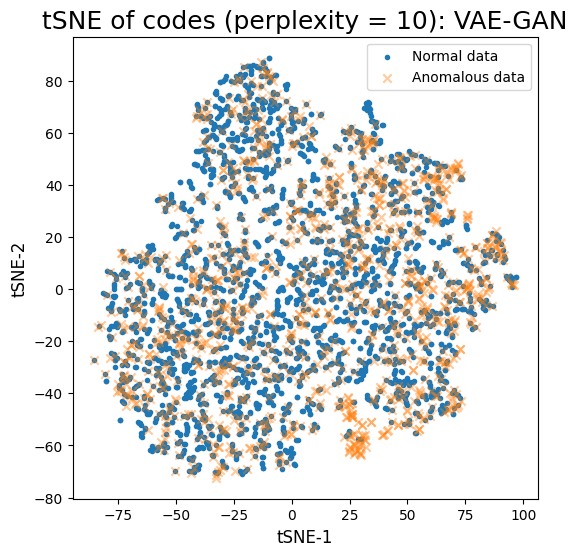

In [46]:
# use TSNE to show code distribution
PERPLEXITY = 10
if True:
    generator.eval()
    full_code = generator.encode(torch.cat((test_data, anomalous_data), dim=0)).detach().numpy()
    full_label = [0 for _ in range(len(test_data))] + [1 for _ in range(len(anomalous_data))]
    from sklearn.manifold import TSNE

    # We want to get TSNE embedding with 2 dimensions
    n_components = 2
    tsne = TSNE(n_components, perplexity=PERPLEXITY)
    #print(full_data.shape)
    tsne_code = tsne.fit_transform(full_code)

if True:
    fig3 = plt.figure(figsize = (6,6))
    ax3 = fig3.add_subplot(1,1,1)
    l1, l2 = len(test_data), len(anomalous_data)
    ax3.scatter(tsne_code[:l1,0], tsne_code[:l1,1], marker=".").set_label('Normal data')
    ax3.scatter(tsne_code[l1:,0], tsne_code[l1:,1], marker="x", alpha=0.4).set_label('Anomalous data')
    ax3.set_title(('tSNE of codes (perplexity = ' + str(PERPLEXITY) + '): ' + 'VAE-GAN'), fontsize = 18)
    ax3.set_xlabel('tSNE-1', fontsize = 12)
    ax3.set_ylabel('tSNE-2', fontsize = 12)
    ax3.legend()



In [47]:
train_X, train_Y, test_X, test_Y = preProcessData_LogisticRegression(raw_data, anomalous_data, trim=TRIM_DATA, trim_threshold=0.98, normalize=NORMALIZE_DATA,
    filterLinearDependencies=True, filter_threshold=0.98, removeNoise=REMOVE_NOISE, noise_threshold=REMOVE_NOISE_THRESHOLD)
#
train_X, train_Y, test_X, test_Y = toTorchTensor(device, train_X, train_Y, test_X, test_Y)
pred_threshold = 0
##
test_X = torch.tensor(np.loadtxt('../data/medical_attack_data_undetected.csv', skiprows=1, delimiter=',')[:,:-1]).to(torch.float)
test_Y = torch.ones(len(test_X), 1).to(torch.float)
##
parameters = {}
parameters["Train precision"] = torch.sum(torch.logical_and((discriminator(train_X) > pred_threshold), (train_Y == 1))) / torch.sum(discriminator(train_X) > pred_threshold)
parameters["Train recall"] = torch.sum(torch.logical_and((discriminator(train_X) > pred_threshold), (train_Y == 1))) / torch.sum(train_Y == 1)
parameters["Test precision"] = torch.sum(torch.logical_and((discriminator(test_X) > pred_threshold), (test_Y == 1))) / torch.sum(discriminator(test_X) > pred_threshold)
parameters["Test recall"] = torch.sum(torch.logical_and((discriminator(test_X) > pred_threshold), (test_Y == 1))) / torch.sum(test_Y == 1)
print(parameters)
print(len(test_X))
print((discriminator(test_X) > pred_threshold).sum())

Train data shape after trim:  (8005, 7)
Train data shape after normalize:  (8005, 7)
Train data shape after filter corrcoef:  (8005, 7)
removeNoise = True ---- remaining Data Shape =  (7863, 7)
{'Train precision': tensor(0.0768), 'Train recall': tensor(1.), 'Test precision': tensor(1.), 'Test recall': tensor(1.)}
1106
tensor(1106)
